# Pretrain Language Model on Wikipedia

In [1]:
from fastai.text.all import *
from fastai.callback.progress import CSVLogger

In [2]:
lang = 'de'
backwards = False
bs=128
vocab_sz = 15000
drop_mult = 0.5
num_workers=18
step = 'lm' # language model

In [3]:
direction = 'fwd' if backwards == False else 'bwd'

In [4]:
wiki = f'{lang}wiki'
path = Path(f'data/{wiki}')
data_path = path/'docs'/'sampled'
model_path = path/'model'/step/direction
spm_path = path/'model'/step/'spm'
lm_fns = [model_path/f'{lang}_wikitext', model_path/f'{lang}_wikitext_vocab.pkl']

# Create Dataloaders

In [11]:
if spm_path.exists():
    tok = SentencePieceTokenizer(lang=lang, max_vocab_sz=vocab_sz, sp_model=spm_path/'spm.model')
    print(f'SentencePiece Model exists - using {spm_path}')
else:
    tok = SentencePieceTokenizer(lang=lang, max_vocab_sz=vocab_sz, cache_dir=spm_path)

SentencePiece Model exists - using data/dewiki/model/lm/spm


If you get `PermissionError: [Errno 13] Permission denied: 'data/dewiki/docs/sampled_tok'` when executing the following cell, make sure the current user has the permissions to read the extracted Wikipedia dump.

In [12]:
dblock = DataBlock(blocks=TextBlock.from_folder(data_path, is_lm=True, tok=tok, backwards=backwards),
                   get_items=get_files,
                   splitter=RandomSplitter(valid_pct=0.1, seed=42),
                  )

dls = dblock.dataloaders(data_path, path=data_path, bs=bs, num_workers=num_workers)

In [13]:
dls.show_batch()

,text,text_
0,"> ▁doc ▁/ ▁< . setzte ▁fort ra če ▁ku ▁xxmaj kar ta o ▁ ▁xxmaj ▁bei , ▁war iert gr emi ▁ ▁london ▁xxmaj ▁nach ▁1966 ▁dieser ▁nachdem , ▁sie ▁die , as ▁ha ▁xxmaj lav dis ▁la ▁xxmaj ▁bei analyse ▁ ▁xxmaj ▁einer ▁mit ▁ausbildung ▁xxmaj e analytisch o psych ▁ e ▁illegal ▁damals ▁eine ▁prag ▁xxmaj ▁in ▁begann ) ▁1937 ▁(* ová ž mr s ▁ ▁xxmaj ▁geborene ,","▁doc ▁/ ▁< . setzte ▁fort ra če ▁ku ▁xxmaj kar ta o ▁ ▁xxmaj ▁bei , ▁war iert gr emi ▁ ▁london ▁xxmaj ▁nach ▁1966 ▁dieser ▁nachdem , ▁sie ▁die , as ▁ha ▁xxmaj lav dis ▁la ▁xxmaj ▁bei analyse ▁ ▁xxmaj ▁einer ▁mit ▁ausbildung ▁xxmaj e analytisch o psych ▁ e ▁illegal ▁damals ▁eine ▁prag ▁xxmaj ▁in ▁begann ) ▁1937 ▁(* ová ž mr s ▁ ▁xxmaj ▁geborene , ová"
1,"▁teil ▁xxmaj ▁seinen , ▁aussicht ▁xxmaj ▁die ▁durch ▁und onne ill ▁gu ▁xxmaj ▁jungen ▁der ▁mit schließung ▁ehe ▁xxmaj stehende ▁bevor ▁seine ▁durch ▁andererseits , fern ei ▁wett ▁zu s ▁italien ▁xxmaj n ▁dichter ▁xxmaj en lateinisch ▁neu ▁den ▁mit , streben ▁be ▁xxmaj ▁sein ▁durch ▁und ▁aufschwung ▁xxmaj ▁kulturellen ▁und en gesellschaftlich ▁ igen es hi ▁ ▁den ▁durch ▁motiviert ▁einerseits n ▁den ▁xxmaj . ▁sein ▁neue ▁völlig ▁eine ▁aber ▁nun","▁xxmaj ▁seinen , ▁aussicht ▁xxmaj ▁die ▁durch ▁und onne ill ▁gu ▁xxmaj ▁jungen ▁der ▁mit schließung ▁ehe ▁xxmaj stehende ▁bevor ▁seine ▁durch ▁andererseits , fern ei ▁wett ▁zu s ▁italien ▁xxmaj n ▁dichter ▁xxmaj en lateinisch ▁neu ▁den ▁mit , streben ▁be ▁xxmaj ▁sein ▁durch ▁und ▁aufschwung ▁xxmaj ▁kulturellen ▁und en gesellschaftlich ▁ igen es hi ▁ ▁den ▁durch ▁motiviert ▁einerseits n ▁den ▁xxmaj . ▁sein ▁neue ▁völlig ▁eine ▁aber ▁nun ▁sollte"
2,"▁und ▁beethoven ▁xxmaj , ▁mozart ▁xxmaj ▁von ▁werke ▁xxmaj ▁sie ▁dem ▁bei , in pianist ▁ ▁xxmaj ▁als ▁auftritt ▁xxmaj ▁öffentlichen ▁ersten ▁ihren konzert s tätigkeit ▁wohl ▁xxmaj ▁einem ▁bei ▁1907 ▁hatte ▁und en s ▁christen ▁xxmaj e ov ▁ ▁xxmaj ▁von in schüler ▁klavier ▁xxmaj ▁wurde ▁sie ▁xxmaj . ted es ▁seh ▁xxmaj a hild ▁ ▁xxmaj in komponist ▁ ▁xxmaj ▁ältere ▁jahre ▁xxmaj ▁zwanzig ▁die ▁sie te ▁kann ▁kindheit ▁xxmaj","▁beethoven ▁xxmaj , ▁mozart ▁xxmaj ▁von ▁werke ▁xxmaj ▁sie ▁dem ▁bei , in pianist ▁ ▁xxmaj ▁als ▁auftritt ▁xxmaj ▁öffentlichen ▁ersten ▁ihren konzert s tätigkeit ▁wohl ▁xxmaj ▁einem ▁bei ▁1907 ▁hatte ▁und en s ▁christen ▁xxmaj e ov ▁ ▁xxmaj ▁von in schüler ▁klavier ▁xxmaj ▁wurde ▁sie ▁xxmaj . ted es ▁seh ▁xxmaj a hild ▁ ▁xxmaj in komponist ▁ ▁xxmaj ▁ältere ▁jahre ▁xxmaj ▁zwanzig ▁die ▁sie te ▁kann ▁kindheit ▁xxmaj ▁ihrer"
3,"e alle bundes ▁( um tri a ▁ ▁xxmaj palast - ba - ▁be e ▁fertiggestellt ▁1927 ▁der ▁war "" e alle kaiser ▁"" ▁der ▁gebäude ▁xxmaj des chen ste ▁heraus ▁xxmaj "". ▁35 e alle kaiser ▁"" ▁der ▁in ▁sitz ▁xxmaj ▁seinen ▁kurzzeitig ersdorf m ▁wil ▁xxmaj ▁amtsgericht ▁xxmaj ▁das ▁hatte ▁1945 ▁jahr ▁xxmaj ▁im ▁xxmaj . ▁raum ▁xxmaj ▁berliner ▁xxmaj ▁westlichen ▁im achse - süd - ▁nord ▁einer ▁status ▁xxmaj","alle bundes ▁( um tri a ▁ ▁xxmaj palast - ba - ▁be e ▁fertiggestellt ▁1927 ▁der ▁war "" e alle kaiser ▁"" ▁der ▁gebäude ▁xxmaj des chen ste ▁heraus ▁xxmaj "". ▁35 e alle kaiser ▁"" ▁der ▁in ▁sitz ▁xxmaj ▁seinen ▁kurzzeitig ersdorf m ▁wil ▁xxmaj ▁amtsgericht ▁xxmaj ▁das ▁hatte ▁1945 ▁jahr ▁xxmaj ▁im ▁xxmaj . ▁raum ▁xxmaj ▁berliner ▁xxmaj ▁westlichen ▁im achse - süd - ▁nord ▁einer ▁status ▁xxmaj en"
4,"▁xxmaj ▁in ▁jahre ▁xxmaj ▁drei ▁er ▁spielte ▁anschließend ▁xxmaj . ▁wurde ▁meister ▁xxmaj ischer lett ▁ ▁2009 s pil s vent ▁ ▁xxmaj k ▁b ▁xxup ▁dem ▁mit ▁er ▁wo , ▁heimat ▁xxmaj ischen lett ▁ ▁seiner ▁in ▁2011 ▁bis ▁spielte ks nie l ē str ▁ ▁xxmaj . spieler ▁basketball ▁xxmaj ischer lett ▁ ▁ein ▁ist ) ▁sowjetunion ▁xxmaj , r s s ▁ ▁xxup ische lett ▁ ▁xxmaj , si","▁in ▁jahre ▁xxmaj ▁drei ▁er ▁spielte ▁anschließend ▁xxmaj . ▁wurde ▁meister ▁xxmaj ischer lett ▁ ▁2009 s pil s vent ▁ ▁xxmaj k ▁b ▁xxup ▁dem ▁mit ▁er ▁wo , ▁heimat ▁xxmaj ischen lett ▁ ▁seiner ▁in ▁2011 ▁bis ▁spielte ks nie l ē str ▁ ▁xxmaj . spieler ▁basketball ▁xxmaj ischer lett ▁ ▁ein ▁ist ) ▁sowjetunion ▁xxmaj , r s s ▁ ▁xxup ische lett ▁ ▁xxmaj 

In [14]:
len(dls.train), len(dls.valid)

(22115, 2439)

# Train Model

In [15]:
learn = language_model_learner(dls, AWD_LSTM, drop_mult=drop_mult, pretrained=False, 
                               metrics=[accuracy, Perplexity()]).to_fp16()
learn.path = model_path.absolute()

SuggestedLRs(lr_min=0.004786301031708717, lr_steep=0.002511886414140463)

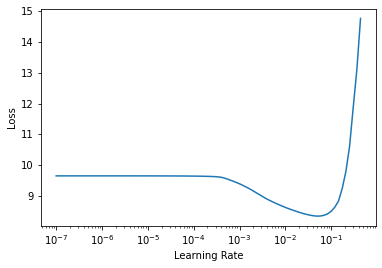

In [16]:
learn.lr_find()

In [17]:
lr = 1e-2
num_epochs = 10

In [18]:
cbs=[CSVLogger(fname=f'history.csv')]

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(num_epochs, lr, cbs=cbs, moms=(0.8, 0.7, 0.8))

epoch,train_loss,valid_loss,accuracy,perplexity,time


# Save Model and Stats

In [ ]:
learn.to_fp32().save(lm_fns[0].absolute(), with_opt=False)

In [ ]:
with open(lm_fns[1], 'wb') as f:
      pickle.dump(learn.dls.vocab, f)

In [ ]:
stats = learn.recorder.values[-1]

train_params = {
    'lang': lang,
    'step': step,
    'backwards': backwards,
    'batch_size': bs,
    'vocab_size': vocab_sz,
    'lr': lr,
    'num_epochs': num_epochs,
    'drop_mult': drop_mult,
    'stats': {
        'train_loss': stats[0],
        'valid_loss': stats[1],
        'accuracy': stats[2],
        'perplexity': stats[3]
    }
}

with open(f'{model_path}/train_params.json', 'w') as f:
    json.dump(train_params, f, ensure_ascii=False, indent=4)